In [13]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import fft
rng = np.random.default_rng()

In [3]:
def euler_step_2D(psi, v_x, T, k_cut, pert):
    psi_k = fft.fft2(psi)
    dpsi_dx = fft.ifft2(1j*KX * psi_k)
    d2psi_d2 = fft.ifft2(-Kdos * psi_k)
    H_k = -0.5 * (hbar**2 / m) * d2psi_d2
    H_V= (V+ g*(np.abs(psi)**2))*psi   
    if pert == True:
        H_sf = 1j*hbar*dpsi_dx*v_x
        H_tot = H_k + H_V + H_sf
    else:
        H_tot = H_k + H_V
    noise_real = rng.normal(loc=0, scale= 1, size= (Nx,Ny))
    noise_im = rng.normal(loc=0, scale= 1, size= (Nx, Ny))
    noise = np.sqrt((hbar*kb*gamma*T)/(dy*dx*dt))*(noise_real + 1j*noise_im)
    psi += -(1j*dt/hbar)*(H_tot)*(1 -1j*gamma)
    psi += -(1j*dt/hbar)*noise
    psi_k_unmasked = fft.fft2(psi)
    k_magnitude = np.sqrt(Kdos)
    mask = k_magnitude <= k_cut
    psi_masked = fft.ifft2(psi_k_unmasked * mask)
    psi_masked *= np.sqrt(N_coh/np.trapezoid(np.trapezoid(np.abs(psi_masked)**2,y, axis=0), x))
    return psi_masked

def derivada_psi(psi, v_x, T, k_cut):
    psi_k = fft.fft2(psi)
    dpsi_dx = fft.ifft2(1j*KX * psi_k)
    d2psi_d2 = fft.ifft2(-Kdos * psi_k)
    H_k = -0.5 * (hbar**2 / m) * d2psi_d2
    H_V= (V+ g*(np.abs(psi)**2))*psi   
    H_sf = 1j*hbar*dpsi_dx*v_x
    H_tot = H_k + H_V + H_sf
    noise_real = rng.normal(loc=0, scale= 1, size= (Nx,Ny))
    noise_im = rng.normal(loc=0, scale= 1, size= (Nx, Ny))
    noise = np.sqrt((hbar*kb*gamma*T)/(dy*dx*dt))*(noise_real + 1j*noise_im)
    rk4_der = -(1j/hbar)*(H_tot)*(1 -1j*gamma)
    rk4_der = -(1j/hbar)*noise
    return rk4_der

def rk4_step_2D(psi, v_x, T, k_cut):
    k1 = derivada_psi(psi, v_x, T, k_cut)
    k2 = derivada_psi(psi + 0.5 * dt * k1, v_x, T, k_cut)
    k3 = derivada_psi(psi + 0.5 * dt * k2, v_x, T, k_cut)
    k4 = derivada_psi(psi + dt * k3, v_x, T, k_cut)
    psi += dt* (k1 + 2.0 * k2 + 2.0 * k3 + k4)/6
    psi_k_unmasked = fft.fft2(psi)
    k_magnitude = np.sqrt(Kdos)
    mask = k_magnitude <= k_cut
    psi_masked = fft.ifft2(psi_k_unmasked * mask)
    psi_masked *= np.sqrt(N_coh/np.trapezoid(np.trapezoid(np.abs(psi_masked)**2,y, axis=0), x))
    return psi_masked 

def momentum(psi):
    psi_conj = np.conjugate(psi)
    psi_k = fft.fft2(psi)
    psi_conj_k = fft.fft2(psi_conj)
    dpsi_dx = fft.ifft2(1j*KX * psi_k)
    dpsiconj_dx = fft.ifft2(1j*KX * psi_conj_k)
    integrand = psi*dpsiconj_dx - psi_conj*dpsi_dx
    mom = np.sum(integrand)*dx*dy
    mom *= 1j*hbar/2
    return np.real(mom)
    
def sf_fraction(psi):
    psi_conj = np.conjugate(psi)
    psi_k = fft.fft2(psi)
    psi_conj_k = fft.fft2(psi_conj)
    dpsi_dx = fft.ifft2(1j*KX * psi_k)
    dpsiconj_dx = fft.ifft2(1j*KX * psi_conj_k)
    integrand = psi*dpsiconj_dx - psi_conj*dpsi_dx
    exp_val = np.real((1j*hbar/2)*np.sum(integrand)*dx*dy)
    mom_tot = N_coh * m * v_x
    sp_frac = 1- exp_val/mom_tot
    sp_frac = np.clip(sp_frac, 0, 1)
    return sp_frac

In [21]:
hbar = 1.054571817e-34
kb = 1.380649e-23
m = 1.4431e-25
g = 0.53e-21*kb
n0 = 9e12
T_BKT = 38e-9
gamma = 0.05
V = 0.0
L_exp = 3e-5
N_tot = int(n0*L_exp**2)
print(N_tot)
# Parámetros malla
dx = 20e-6/64
dy = dx
Lx = L_exp  # Longitud del dominio x
Ly = L_exp
N = int(L_exp/dx)
Nx = N
Ny = N
x = np.linspace(-Lx/2, Lx/2, Nx, endpoint=False)
y = np.linspace(-Ly/2, Ly/2, Ny, endpoint=False)
X ,Y = np.meshgrid(x, y)
R = np.sqrt(X**2 + Y**2)
Rmax = R.max()
kx = fft.fftfreq(Nx, d=dx) * 2 * np.pi  # Frecuencias en x
ky = fft.fftfreq(Ny, d=dy) * 2 * np.pi  # Frecuencias en y
KX, KY = np.meshgrid(kx, ky)  # Malla 2D de frecuencias
Kdos = KX**2 + KY**2
print(N)
t_total = 0.3
dt= 0.1e-5
n_steps = int(t_total/dt)

8100
96


In [ ]:
# valor de la fraccion superfluida a T_BKT
valor = 2*T_BKT*m*kb/(hbar**2*np.pi)/n0
valor

## SF vs T ##

### $f_s$ vs T ###

In [23]:
%%time

gamma = 0.05
a = 0.3
superfluid = []
Ts = []
T1 = np.linspace(0, 0.8*T_BKT, 8)
T2 = np.linspace(0.8*T_BKT, 1.5*T_BKT, 15)
# T_array = np.unique(np.concatenate((T1, T2)))
T_array = np.linspace(0, 1.5*T_BKT, 15)
sfs2 = []
sfs_var2 = []
for T in T_array:
    T= 1.5*T_BKT
    # T = 15e-9
    sf_array = []
    sf_altern_arr = []
    timer = []
    N_inc = int(L_exp**2*(m/(2*np.pi))*(kb/hbar**2)*np.log(2)*T)
    N_coh = N_tot - N_inc
    mu = g*N_coh/(L_exp**2)
    E_cut = kb*T*np.log(2) + mu
    k_cut = np.sqrt(E_cut*2*m/hbar**2)
    sound_v = np.sqrt(g*(N_coh/L_exp**2)/m)
    v_x = a*sound_v
    psi = np.sqrt(N_coh/L_exp**2)*np.ones((Nx,Ny)).astype(np.complex128)
    for i in range(n_steps):
        # timer.append(i)
        if i%int(n_steps/10) == 0:
            print(i/n_steps)
        psi = euler_step_2D(psi, v_x, T, k_cut, True)
        if i>=int(0.6*n_steps):
            sf = sf_fraction(psi)
            sf_array.append(sf)
    sf_mean = np.mean(sf_array)
    sf_var = np.var(sf_array)
    sfs2.append(sf_mean)
    sfs_var2.append(sf_var)
    print(T, sf_mean, np.sqrt(sf_var)/sf_mean)
    break

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
5.700000000000001e-08 0.22039218395591673 0.3883877617335551
CPU times: total: 6min 38s
Wall time: 6min 39s


In [19]:
# sfs : 0.3c, tiempo corto
# sfs1 : 0.3c tiempo largo
# sfs2 : 0.1c tiempo largo
datos = np.column_stack((T_array, sfs2, sfs_var2))
np.savetxt('sf_fraction_N150_03c.txt', datos, delimiter=' ')

In [15]:
T_array1, sfs1, sfs_var1 = np.loadtxt("sf_fraction_N100_03c.txt", unpack=True)

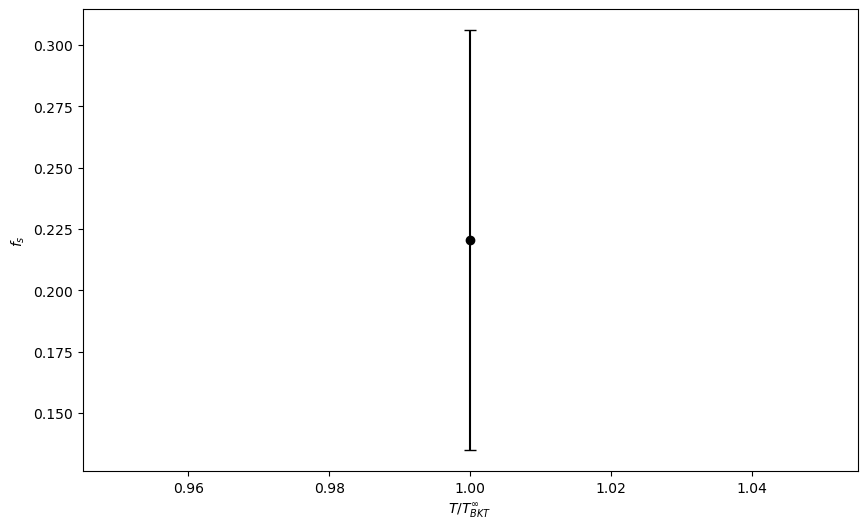

In [35]:
xd = [1]
plt.figure(figsize=(10,6))
# plt.plot(T_array, sfs, "-o")
# plt.plot(T_array, sfs1, "-s")
# plt.plot(T_array, sfs2, "-o")
# plt.errorbar(T_array/T_BKT, sfs, yerr = np.sqrt(sfs_var), fmt="o", color = "k", ecolor = "k", capsize = 4)
plt.errorbar(xd, sfs2, yerr = np.sqrt(sfs_var2), fmt="-o", color = "k", ecolor = "k", capsize = 4)
# plt.errorbar(T_array1/T_BKT, sfs1, yerr = np.sqrt(sfs_var1), fmt="-o", color = "red", ecolor = "red", capsize = 4)
# plt.plot(T_array1, sfs1, "o")
plt.xlabel(r"$T/T_{BKT}^{\infty}$")
plt.ylabel(r"$f_s$")
# plt.grid(True)
# plt.savefig("fs_werr_01c.png", dpi=300)
plt.show()

In [ ]:
T_array = np.array(Ts)
plt.figure(figsize=(8,6))
# plt.plot(T_array/T_BKT, superfluid1, "-o", label = "N = 3600")
# plt.plot(T_array/T_BKT, superfluid, "-o", label = "N = 1800")
plt.plot(T_array/1e-9, superfluid, "-o", label = "N = 3600")
# plt.plot(T_array/1e-9, sf_altern_arr, "-s")
T_long = np.linspace(0,2*T_BKT, 100)
sf_density = 2*m*kb*T_long/(np.pi*hbar**2)
# plt.plot(T_long/T_BKT, sf_density/n0)
# plt.axvline(x = 32, color = "black")
plt.axvline(x = 38, color = "black")
plt.xlabel(r"$T(nK)$")
plt.ylabel(r"$f_s$")
plt.xlim(0, 80)
plt.legend()
# plt.savefig("vx_comp.png")
plt.show()

### $f_s$ vs $v_x$ ###  

a = 0.5

dt a T_BKT = 0.2e-5

In [ ]:
t_total = 0.3
dt= 0.6e-5
n_steps = int(t_total/dt)

In [ ]:
%%time
gamma = 0.05
T = 0.5*T_BKT
N_inc = int(L_exp**2*(m/(2*np.pi))*(kb/hbar**2)*np.log(2)*T)
N_coh = N_tot - N_inc
print(N_coh)
mu = g*N_coh/(L_exp**2)
E_cut = kb*T*np.log(2) + mu
k_cut = np.sqrt(E_cut*2*m/hbar**2)
sound_v = np.sqrt(g*(N_coh/L_exp**2)/m)
# sound_v = np.sqrt(g*n0/m)
sf_tot = []
vx_frac = []
for a in np.linspace(0.1, 1, 5):
    sf_array = []
    iter_num = []
    v_x = a*sound_v
    psi = np.sqrt(N_coh/L_exp**2)*np.ones((Nx,Ny)).astype(np.complex128)
    for i in range(n_steps):
        if i%int(n_steps/10) == 0:
            print(i/n_steps)
        psi = euler_step_2D(psi, v_x, T, k_cut, True)
        sf = sf_fraction(psi)
        sf_array.append(sf)
        iter_num.append(i)
    plt.plot(iter_num, sf_array)
    plt.show()
    sf_mean = np.mean(sf_array[int(0.6*n_steps):])
    print(sf_mean)
    sf_tot.append(sf_mean)
    vx_frac.append(a)
    print("vx",a,"sf",sf_tot[-1])

In [ ]:
plt.plot(vx_frac, sf_tot, "o")
plt.xlabel(r"$v_x / c$")
plt.ylabel(r"$f_s$")
plt.title(r"$\gamma = 0.05, T_BKT$")
# plt.savefig("sf_vs_vx_02.png")
plt.show()